# Feature Engineering 

In [31]:
import pandas as pd
import numpy as np 
data = pd.read_csv('data/raw/BankChurners.csv')
drop_cols = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]

In [32]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt 

In [33]:
from sklearn.preprocessing import MinMaxScaler

# 나이변수

In [34]:
# 나이(Customer_Age)를 5개 구간으로 나누어 새로운 범주형 변수 생성
bins = [20, 30, 40, 50, 60, 70]
labels = ['20대', '30대', '40대', '50대', '60대+']
data['Age_Group'] = pd.cut(data['Customer_Age'], bins=bins, labels=labels, right=False)

# 결과 확인 (상위 5개 행)
# | Customer_Age | Age_Group |
# |:-------------|:----------|
# | 45           | 40대       |
# | 49           | 40대       |
# | 51           | 50대       |
# | 40           | 40대       |
# | 40           | 40대       |

# 성별 변수 

In [35]:
# 성별(Gender) 변수를 One-Hot Encoding으로 변환
# drop_first=True로 설정하여 다중공선성을 방지합니다 (Gender_F는 Gender_M으로 설명 가능).
data_encoded = pd.get_dummies(data, columns=['Gender'], prefix='Gender', drop_first=True)

# 결과 확인: Gender_M 열이 추가됨
# | Gender_M |
# |:---------|
# | 1        | (Male)
# | 0        | (Female)
# | 1        | (Male)
# | 0        | (Female)
# | 1        | (Male)

In [36]:
# 'Education_Level', 'Marital_Status', 'Income_Category' 등 
# 모든 범주형 변수에 대해 One-Hot Encoding을 적용.

# drop_first=True는 다중공선성을 방지하기 위해 첫 번째 범주를 제거.
categorical_cols = ['Gender', 'Marital_Status', 'Education_Level', 'Income_Category', 'Card_Category']
df_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 'Unknown' 범주는 자동으로 'Marital_Status_Unknown' 등의 새로운 열로 인코딩.

print("--- One-Hot Encoding 결과 (Gender, Marital_Status 열 변화) ---")
print(data_encoded[[col for col in data_encoded.columns if 'Gender_' in col or 'Marital_Status_' in col]].head().to_markdown(index=False))

--- One-Hot Encoding 결과 (Gender, Marital_Status 열 변화) ---
|   Gender_M |
|-----------:|
|          1 |
|          0 |
|          1 |
|          0 |
|          1 |


In [37]:
data['Log_Total_Trans_Amt'] = np.log1p(data['Total_Trans_Amt'])

print("--- 로그 변환 결과 (Log_Total_Trans_Amt 열 추가) ---")
print(data[['Total_Trans_Amt', 'Log_Total_Trans_Amt']].head().to_markdown(index=False, floatfmt=".4f"))

--- 로그 변환 결과 (Log_Total_Trans_Amt 열 추가) ---
|   Total_Trans_Amt |   Log_Total_Trans_Amt |
|------------------:|----------------------:|
|         1144.0000 |                7.0432 |
|         1291.0000 |                7.1639 |
|         1887.0000 |                7.5433 |
|         1171.0000 |                7.0665 |
|          816.0000 |                6.7056 |


In [38]:
# pip install tabulate 

# 고객활동점수 + Risk Score

In [39]:
# 고객활동점수율 기반 Feature

data["Activity_Score"] = (
    data["Total_Trans_Ct"] * 0.6 +
    data["Contacts_Count_12_mon"] * (-0.3) +
    data["Months_Inactive_12_mon"] * (-0.5)
)

#전액 사용율 기반 Feature
data["Risk_Score"] = (
    data["Total_Revolving_Bal"] * 0.4 +
    data["Avg_Utilization_Ratio"] * 0.6
)

# 로그 변환 (왜도 높은 컬럼들 처리)


In [40]:
# 로그 변환 (왜도 높은 컬럼들 처리)
log_cols = ["Total_Trans_Amt", "Total_Revolving_Bal"]
for col in log_cols:
    if col in data.columns:
        data[f"log_{col}"] = np.log1p(data[col])

# 상호변수 생성 (Feature)

In [41]:
# 상호작용 변수 생성
data["Activity_Index"] = data["Total_Trans_Amt"] * data["Total_Trans_Ct"]
data["Amt_per_Contact"] = data["Total_Trans_Amt"] / (data["Contacts_Count_12_mon"] + 1)

# 위험도 기반 
data["Risk_Score"] = (
    data["Avg_Utilization_Ratio"] * 0.6 +
    data["Total_Revolving_Bal"] * 0.4
)

#원핫 인코딩
data = pd.get_dummies(data, drop_first=True)

In [42]:
# 기본 스캐일링
scaler = MinMaxScaler()
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns

data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [ ]:
print("Feature Engineering Finalized")
data.head()

Feature Engineering Finalized


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Age_Group_30대,Age_Group_40대,Age_Group_50대,Age_Group_60대+
0,0.504929,0.404255,0.6,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,...,False,False,False,False,False,False,False,True,False,False
1,0.920398,0.489362,1.0,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,...,False,True,False,False,False,False,False,True,False,False
2,0.049060,0.531915,0.6,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,...,True,False,False,False,False,False,False,False,True,False
3,0.514130,0.297872,0.8,0.488372,0.4,0.666667,0.166667,0.056676,1.000000,0.022977,...,False,True,False,False,False,False,False,True,False,False
4,0.008517,0.297872,0.6,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,...,False,False,False,False,False,False,False,True,False,False


# 추가 Feature

**월별 활동 패턴 기반 Feature** 

1년 전 대비 최근 거래 횟수가 얼마나 변했는지

감소 → 이탈 신호

In [ ]:
# 월별 활동 패턴 기반 Feature

data["Trans_Change_Ratio"] = (
    data["Total_Trans_Ct"] / (data["Total_Ct_Chng_Q4_Q1"] + 1)
)

**비활성 기간 Feature** 

비활성 기간 × 사용률

“한도를 많이 쓰는데 활동이 뜸함 = 이탈 직전” 케이스 포착


In [58]:
data["Inactivity_Score"] = (
    data["Months_Inactive_12_mon"] * data["Avg_Utilization_Ratio"]
)

# Feature Selection

Correlation 기반 Feature Selection
→ 타겟 과 상관 높은 변수만 확인

In [44]:
print(data.columns.tolist())

[col for col in data.columns if "Attrition" in col]
[col for col in data.columns if "CLIENT" in col.upper()]
[col for col in data.columns if "Naive" in col]

['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Log_Total_Trans_Amt', 'Activity_Score', 'Risk_Score', 'log_Total_Trans_Amt', 'log_Total_Revolving_Bal', 'Activity_Index', 'Amt_per_Contact', 'Attrition_Flag_Existing Customer', 'Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 'Education_Level_High School', 'Education_Level_Post-Graduate', 'Education_Level_Uneducated', 'Education_Level_Unknown', 'Marital_Status_Married', 'Marital_Status_Single', 

['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

In [45]:
print(data.columns.tolist())
[col for col in data.columns if "Attrition" in col]

['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Log_Total_Trans_Amt', 'Activity_Score', 'Risk_Score', 'log_Total_Trans_Amt', 'log_Total_Revolving_Bal', 'Activity_Index', 'Amt_per_Contact', 'Attrition_Flag_Existing Customer', 'Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 'Education_Level_High School', 'Education_Level_Post-Graduate', 'Education_Level_Uneducated', 'Education_Level_Unknown', 'Marital_Status_Married', 'Marital_Status_Single', 

['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
 'Attrition_Flag_Existing Customer']

In [46]:
data = pd.read_csv("data/raw/BankChurners.csv")

# 1) Attrition Flag 원본이 없는 경우 → One-hot 인코딩 기반으로 생성
if "Attrition_Flag" not in data.columns:
    if "Attrition_Flag_Existing Customer" in data.columns:
        data["Attrition_binary"] = data["Attrition_Flag_Existing Customer"].apply(
            lambda x: 0 if x == True else 1
        )
else:
    data["Attrition_binary"] = data["Attrition_Flag"].map({
        "Existing Customer": 0,
        "Attrited Customer": 1
    })

# 2) 필요 없는 3개 컬럼 제거
drop_cols = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]
data = data.drop(columns=drop_cols, errors="ignore")

# 3) Correlation 계산을 위한 numeric만 선택
numeric_df = data.select_dtypes(include=[np.number])

corr = numeric_df.corr()["Attrition_binary"].sort_values(ascending=False)

print("=== Correlation 기반 Top Features ===")
print(corr.head(15))

=== Correlation 기반 Top Features ===
Attrition_binary            1.000000
Contacts_Count_12_mon       0.204491
Months_Inactive_12_mon      0.152449
Dependent_count             0.018991
Customer_Age                0.018203
Months_on_book              0.013687
Avg_Open_To_Buy            -0.000285
Credit_Limit               -0.023873
Total_Amt_Chng_Q4_Q1       -0.131063
Total_Relationship_Count   -0.150005
Total_Trans_Amt            -0.168598
Avg_Utilization_Ratio      -0.178410
Total_Revolving_Bal        -0.263053
Total_Ct_Chng_Q4_Q1        -0.290054
Total_Trans_Ct             -0.371403
Name: Attrition_binary, dtype: float64


# Random Forest
→ 비선형 패턴까지 반영한 중요도 평가

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [48]:
data = pd.read_csv("data/raw/BankChurners.csv")

# 2) Attrition_binary 생성 (OHE 기반)
if "Attrition_Flag_Existing Customer" in data.columns:
    data["Attrition_binary"] = data["Attrition_Flag_Existing Customer"].apply(
        lambda x: 0 if x == True else 1
    )
else:
    data["Attrition_binary"] = data["Attrition_Flag"].map({
        "Existing Customer": 0,
        "Attrited Customer": 1
    })

drop_cols = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]
data = data.drop(columns=drop_cols, errors="ignore")

numeric_df = data.select_dtypes(include=[np.number])

X = numeric_df.drop(columns=["Attrition_binary"], errors="ignore")
y = numeric_df["Attrition_binary"]

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)

top_features = importances.sort_values(ascending=False).head(20)

print("=== RandomForest 기반 Feature Importance TOP 20 ===")
print(top_features)

=== RandomForest 기반 Feature Importance TOP 20 ===
Total_Trans_Amt             0.193874
Total_Trans_Ct              0.175644
Total_Ct_Chng_Q4_Q1         0.111389
Total_Revolving_Bal         0.110271
Total_Relationship_Count    0.067759
Total_Amt_Chng_Q4_Q1        0.067145
Avg_Utilization_Ratio       0.065862
Customer_Age                0.037661
Credit_Limit                0.035902
Avg_Open_To_Buy             0.035309
Months_Inactive_12_mon      0.028795
Contacts_Count_12_mon       0.028586
Months_on_book              0.028062
Dependent_count             0.013741
dtype: float64


In [49]:
# pip install xgboost

In [50]:
print(data.columns.tolist())


['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Attrition_binary']


# RandomForest Feature Importance Graph 

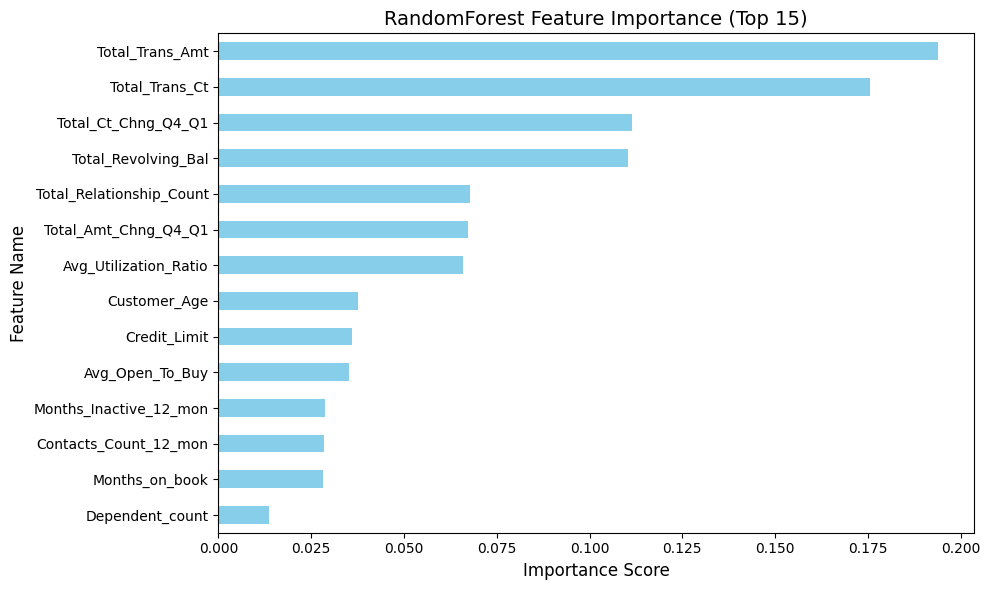

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1) 데이터 가져오기 
data = pd.read_csv("data/raw/BankChurners.csv")

# 2) Attrition_binary 생성
data["Attrition_binary"] = data["Attrition_Flag"].map({
    "Existing Customer": 0,
    "Attrited Customer": 1
})

# 3) 불필요한 컬럼 X
drop_cols = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]
data = data.drop(columns=drop_cols, errors="ignore")


# 4) 숫자형 데이터 선택
numeric_df = data.select_dtypes(include=[np.number])

X = numeric_df.drop(columns=["Attrition_binary"], errors="ignore")
y = numeric_df["Attrition_binary"]

# 결측치 처리
X = X.fillna(0)

# 5) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6) RandomForest 모델 학습
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Feature Importance 계산
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)


# 7) 그래프 생성
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title("RandomForest Feature Importance (Top 15)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.tight_layout()
plt.show()

# XGBoost 

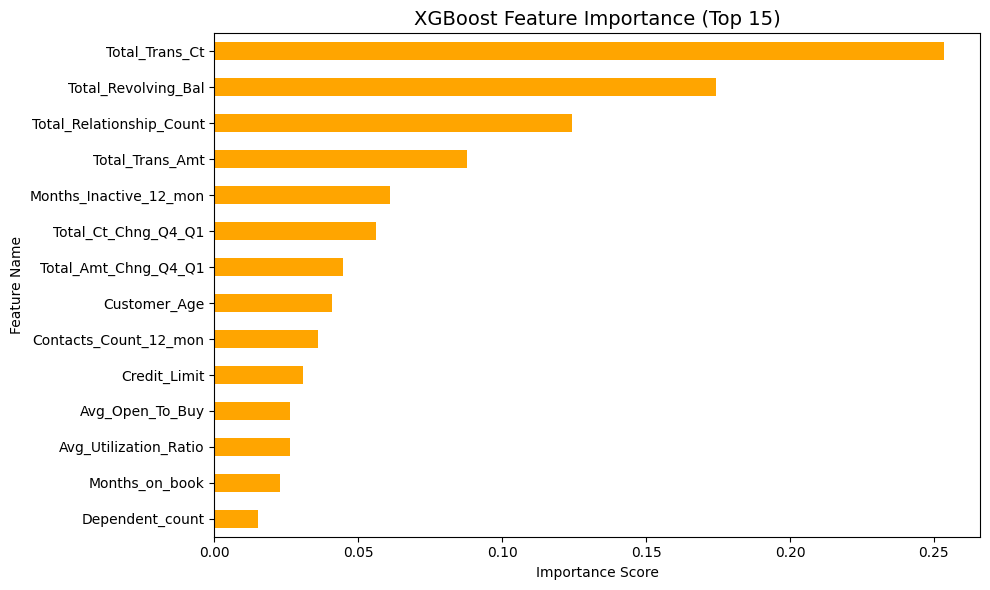


=== XGBoost 상위 Feature 15개 ===
Total_Trans_Ct              0.253355
Total_Revolving_Bal         0.174433
Total_Relationship_Count    0.124324
Total_Trans_Amt             0.087620
Months_Inactive_12_mon      0.061089
Total_Ct_Chng_Q4_Q1         0.056060
Total_Amt_Chng_Q4_Q1        0.044736
Customer_Age                0.041010
Contacts_Count_12_mon       0.036045
Credit_Limit                0.030795
Avg_Open_To_Buy             0.026407
Avg_Utilization_Ratio       0.026238
Months_on_book              0.022710
Dependent_count             0.015177
dtype: float32

XGBoost 모델 정확도 테스트용:
Train Score: 0.9983
Test Score:  0.9640


In [52]:
numeric_df = data.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=["Attrition_binary"], errors="ignore")
y = numeric_df["Attrition_binary"]

# 결측치 처리
X = X.fillna(0)

# 5) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6) XGBoost 모델 학습
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

# 7) Feature Importance 계산
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_xgb = xgb_importance.sort_values(ascending=False).head(15)

# 8) 그래프 출력
plt.figure(figsize=(10, 6))
top_xgb.sort_values().plot(kind='barh', color='orange')
plt.title("XGBoost Feature Importance (Top 15)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# 9) 추가 분석 결과 출력
print("\n=== XGBoost 상위 Feature 15개 ===")
print(top_xgb)

print("\nXGBoost 모델 정확도 테스트용:")
print(f"Train Score: {xgb_model.score(X_train, y_train):.4f}")
print(f"Test Score:  {xgb_model.score(X_test, y_test):.4f}")

In [53]:

# pip install xgboost import XGBClassifier

In [54]:
# import xgboost
# print(xgboost.__version__)

In [55]:
#from xgboost import XGBClassifier
